In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Used to do plots
%matplotlib inline

import nltk 
from nltk.corpus import stopwords # Stopwords 
from nltk.tokenize import word_tokenize # Word_tokenizer
from nltk.stem.porter import PorterStemmer
from pattern.text.en import singularize

from pandarallel import pandarallel # Parallel workers on pandas dataframe

import unidecode
import re 
import time
import string
import statistics

from datetime import datetime

import contractions

In [2]:
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
stop = stopwords.words('english') # Set of stopwords

words = set(nltk.corpus.words.words()) # Set of meaniningful words

### Data Load

In [4]:
df_reviews = pd.read_json('IMDB_reviews.json', lines=True) 

In [5]:
# Print datasets shape
print('User reviews shape: ', df_reviews.shape)

User reviews shape:  (573913, 7)


In [6]:
# Get an idea about the reviews dataset
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [19]:
df_reviews.sort_values(by='review_date', ascending =False)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
112052,9 September 2017,tt1536537,ur24039506,False,The main question bothered me throughout all m...,9,Breedingwood
265585,9 September 2017,tt1396484,ur56441196,False,"Dare I say it, the cheesy 1990 mini-series is ...",5,Disappointing
84030,9 September 2017,tt3011894,ur80261008,False,"6 stories, 6 lifes, all connected by two thing...",8,Evolution of humanity
265664,9 September 2017,tt1396484,ur25709856,False,OK so firstly I see myself as a horror fan and...,4,Things really do float down here. Like this TURD
265659,9 September 2017,tt1396484,ur3081887,False,I just don't know. This was a well directed fi...,2,Not sure why but didn't enjoy it at all after ...
...,...,...,...,...,...,...,...
510797,1 April 1999,tt0111282,ur0149753,False,"""Stargate"" the movie is one of those Saturday ...",7,A harmless way to pass a couple of hours
514058,1 April 1999,tt0114369,ur0254390,False,This is one of the more memorable films I ever...,10,Come join the Dark Side
546856,1 April 1999,tt0120863,ur0283047,False,"There are few things I regret in life, however...",1,Time is a very valuable gift.
479465,1 April 1999,tt0099685,ur0276960,False,GoodFellas is so good for so many reasons. The...,10,The Best Mob Movie Ever!


In [7]:
# Analyze the type of the columns and non-null values of them
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


### EDA

Data Distribution

Percentage distribution in the dataset of spoilers and not spoilers 

False    73.7
True     26.3
Name: is_spoiler, dtype: float64


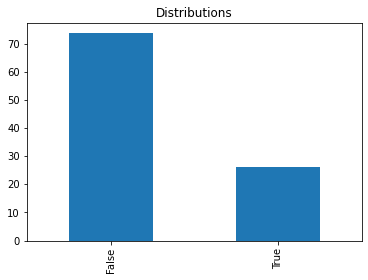

In [8]:
print('Percentage distribution in the dataset of spoilers and not spoilers \n')

# Compute distribution between classes
print(round(df_reviews.is_spoiler.value_counts(normalize=True)*100,2)) 
# Plot distribution between classes 
round(df_reviews.is_spoiler.value_counts(normalize=True)*100,2).plot(kind='bar')

plt.title('Distributions')
plt.show()

Missing Value

In [9]:
# Count missing values for each column
count = df_reviews.isnull().sum().sort_values(ascending=False)

# Compute percentage 
percentage = ((df_reviews.isnull().sum()/len(df_reviews)*100)).sort_values(ascending=False)

# Concatenate count and percentage arrays and print them 
missing_data = pd.concat([count,percentage],axis=1, keys=['Count','Percentage'])

print(missing_data)

                Count  Percentage
review_date         0         0.0
movie_id            0         0.0
user_id             0         0.0
is_spoiler          0         0.0
review_text         0         0.0
rating              0         0.0
review_summary      0         0.0


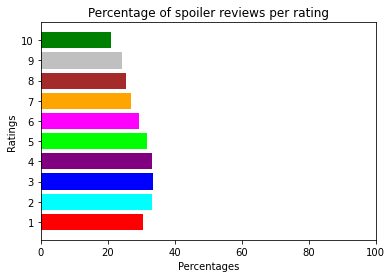

In [10]:
group = df_reviews.groupby('rating') # Groupby rating
 # Get only the spoiler reviews and group them by rating
group_is_spoiler = df_reviews[df_reviews['is_spoiler'] == True].groupby('rating')
tot_review_for_vote = group.size() # Get the number of reviews foreach vote
tot_spoiler_for_vote = group_is_spoiler.size() # Get the number of spoiler review foreach vote
percentage = ((tot_spoiler_for_vote / tot_review_for_vote) * 100) # Compute the %

# Print % graph

y_axis = ['1', '2', '3', '4', '5', '6','7','8','9','10']
x_axis = percentage.tolist()

plt.barh(y_axis,x_axis,color=['red','cyan','blue','purple','lime','magenta','orange','brown','silver','Green'])
plt.xlim(0,100)
plt.title('Percentage of spoiler reviews per rating')
plt.ylabel('Ratings')
plt.xlabel('Percentages')
plt.show()

Checking spoiler distribution for some selected words

In [11]:
def compare_review_by_word(word,df_reviews):
    
    # Create the name for the column that will be added to the dataset
    column_name = 'contains_word_' + word 
    # Filtering reviews that contains the word "word"
    df_reviews[column_name] = df_reviews['review_text'].apply(lambda x: word.lower() in x.lower()) 
    
    # Count the number of reviews that contains the word "word"
    n_reviews_with_word = df_reviews[df_reviews[column_name] == True].shape[0]
    # Count the number of reviews that are spoiler and contains the word "word"
    spoilers_with_word = df_reviews[(df_reviews['is_spoiler'] == True) & (df_reviews[column_name] == True)].shape[0]
    # Count the number of reviews that are NOT spoiler and contains the word "word"
    not_spoilers_with_word = df_reviews[(df_reviews['is_spoiler'] == False) & (df_reviews[column_name] == True)].shape[0]
    # Count the number of spoilers in total
    total_spoilers = df_reviews[(df_reviews['is_spoiler'] == True)].shape[0]
    
    print("Spoiler reviews that contain the word " + word + ": " + str(spoilers_with_word))
    print("Not spoiler reviews that contain the word " + word + ": " + str(not_spoilers_with_word))
    print("Total number of spoiler reviews: " + str(total_spoilers))
    print("\n--------------------------------------------------------------- \n")
    
    # -------------------------------- #
    
    # Plot the graphs 
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15)) #ax1,ax2 refer to your two pies
    fig.tight_layout(pad = 10.0)
    
    # Graph that compare the number of reviews that are spoiler/not spoiler and contains the word "word"
    labels = ["Spoiler", "Not spoiler"]
    values = np.array([(spoilers_with_word/n_reviews_with_word)*100,(not_spoilers_with_word/n_reviews_with_word)*100 ])
    ax1.pie(values,labels = labels,colors = ['#ff6361','#ffa600'],autopct='%1.2f%%') #plot first pie
    ax1.set_title('Reviews containing the word ' + word)

    # Graph that compare the number of reviews in total that contains/not contains the word "word" 
    labels = ["Containing the word " + word, "Not containing the word " + word]
    values = np.array([(spoilers_with_word/total_spoilers)*100,((total_spoilers - spoilers_with_word)/total_spoilers)*100 ])
    ax2.pie(values,labels = labels,colors = ['#ff6361', '#77B1E0'],autopct = '%1.2f%%') #plot second pie
    ax2.set_title('Spoiler reviews')

    # Remove the column created
    df_reviews = df_reviews.drop([column_name], axis=1)
    
    return df_reviews

Spoiler reviews that contain the word spoiler: 19018
Not spoiler reviews that contain the word spoiler: 7418
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 

Spoiler reviews that contain the word die: 48060
Not spoiler reviews that contain the word die: 92520
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 

Spoiler reviews that contain the word win: 47468
Not spoiler reviews that contain the word win: 96692
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 



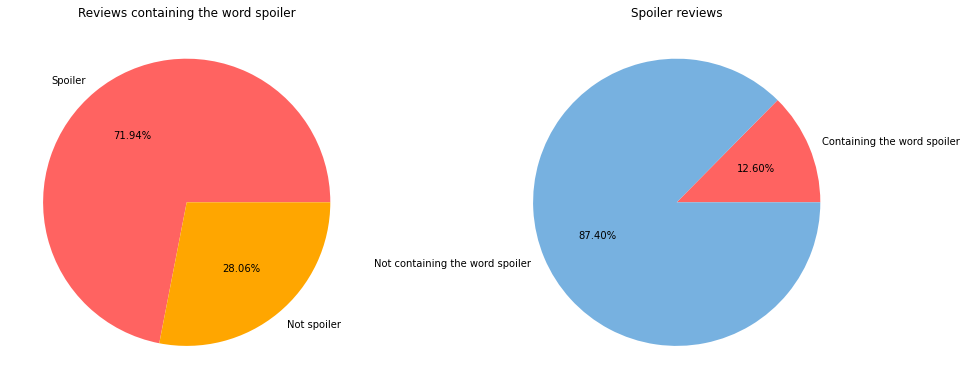

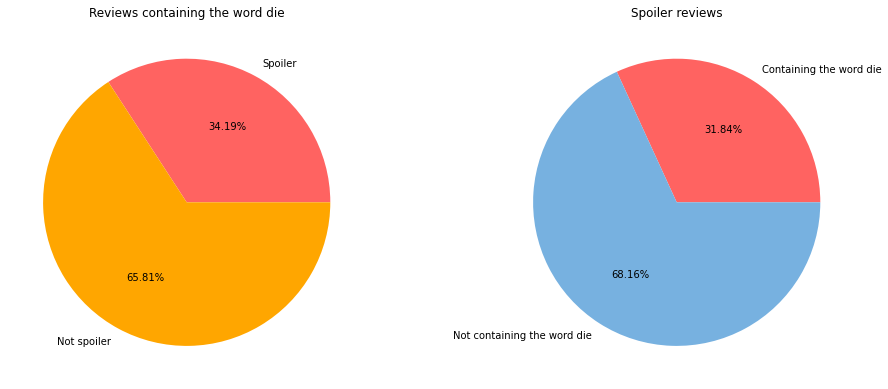

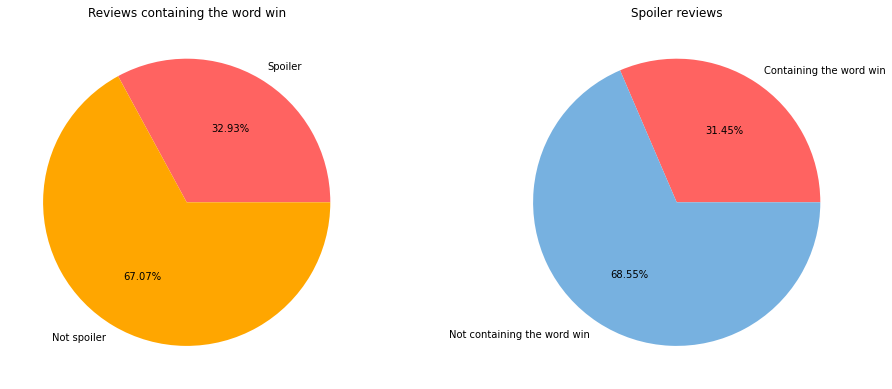

In [12]:
# Plot the pies for words "spoiler", "die" and "win".
df_reviews = compare_review_by_word('spoiler',df_reviews)
df_reviews = compare_review_by_word('die',df_reviews)
df_reviews = compare_review_by_word('win',df_reviews)

Average number of words for spoiler and not spoiler reviews
- We have analyzed if the review length is a discriminant respect to the spoiler label. We have found that in average the number of words used in the spoiler review is higher than in not spoiler reviews.

avg words for spoiler reviews: 335
avg words for not spoiler reviews: 232


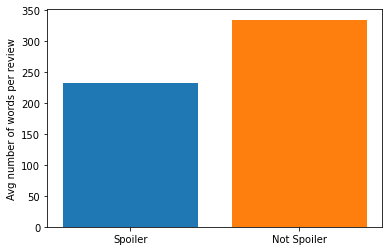

In [13]:
# Compute the number of words foreach review
df_reviews['number_of_words_in_review'] = df_reviews['review_text'].apply(lambda x: len(x.split(" ")))

# Compute the mean for spoiler and not spoiler reviews
avg_length_of_spoilers = df_reviews.groupby('is_spoiler').mean()['number_of_words_in_review']

# Print values
print('avg words for spoiler reviews: ' + str('{:.0f}'.format(avg_length_of_spoilers[1])))
print('avg words for not spoiler reviews: ' + str('{:.0f}'.format(avg_length_of_spoilers[0])))

# ---- PLOT ----- #

plt.bar('Spoiler', avg_length_of_spoilers[0])
plt.bar('Not Spoiler', avg_length_of_spoilers[1])

plt.ylabel('Avg number of words per review')

plt.show()

# Remove the column created
df_reviews = df_reviews.drop(['number_of_words_in_review'], axis=1)

In [14]:
df_reviews_dataset = df_reviews

### Data Preprocessing

In [15]:
from nltk.tokenize import sent_tokenize

In [16]:
df_reviews_dataset['review_text'] = df_reviews_dataset['review_text'].apply(str)

df_reviews_dataset['review_text_count'] = df_reviews_dataset['review_text'].apply(sent_tokenize).tolist()
df_reviews_dataset['review_text_count'] = df_reviews_dataset['review_text_count'].apply(len)

df_reviews_dataset = df_reviews_dataset[df_reviews_dataset['review_text_count'] < 10]

In [17]:
len(df_reviews_dataset)

279670

Data Cleaning

In [18]:
# Remove links from text
def remove_links(text):
    """
    This function will remove links from the 
    text contained within the Dataset.
       
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" with removed links. 
    """
    
    text = re.sub(r'http\S+', '', text)
    return text

In [19]:
# Remove accented characters
def accented_characters_removal(text):
    """
    This function will remove accented characters from the 
    text contained within the Dataset.
       
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" with removed accented characters.  
    """
    
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text) 
    
    return text

In [20]:
# Remove repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
    """
    
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    
    return Final_Formatted

In [21]:
# Expand contraction words
def expand_contractions(text):
    """
    This Function will expands contractions in words.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with expanded contractions .  
    """
    
    # creating an empty list
    expanded_words = []    
    for word in text.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word)) 
    
    String_Of_tokens = ' '.join(expanded_words)
    
    return String_Of_tokens

In [22]:
# Remove special characters
def removing_special_characters(text):
    """
    This Function will remove special characters (including punctualization).
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with special characters removed.  
    """
    
    pattern = r"[^a-zA-Z]"
    text = re.sub(pattern,' ', text)
    
    return text

In [23]:
port_stemmer = PorterStemmer() # Creating the stemmer

# Apply Stemming, remove stopwords, remove meaninglessWords
def stemming_stopwords_meaninglessWords(text):
    """
    This Function will remove meaningless words, stopwords and apply stemming.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with meaningless and stopwords removed, stemming applied. 
    """

    tokens = word_tokenize(text) # Tokenizing the text 
    
    text_1 = ' '.join([
        port_stemmer.stem(token) for token in tokens if token not in stop and singularize(token) in words])
    
    text_2 = ' '.join([
        singularize(token) for token in tokens if token not in stop and singularize(token) in words
        ]) 
        
    return text_1, text_2

In [24]:
# Text cleaning

def text_clean(text):
    
    text = text.lower()
    
    text = remove_links(text)
    
    text = expand_contractions(text)
    
    text = accented_characters_removal(text)
    
    text = removing_special_characters(text)

    text = reducing_incorrect_character_repeatation(text)
    
    text_1, text_2 = stemming_stopwords_meaninglessWords(text)
    
    return text_1, text_2

In [25]:
# Example of text cleaning

example_text = "http://google.com this IS treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ?"

print("--- Initial text example ---")
print(example_text,"\n")

print("--- Lower function ---")
example_text = example_text.lower()
print(example_text,"\n")

print("--- Remove_Links function ---")
example_text = remove_links(example_text)
print(example_text,"\n")

print("--- Remove_Links function ---")
example_text = expand_contractions(example_text)
print(example_text,"\n")

print("--- Remove_Accented_Characters function ---")
example_text = accented_characters_removal(example_text)
print(example_text,"\n")

print("--- Remove_Special_Characters function ---")
example_text = removing_special_characters(example_text)
print(example_text,"\n")

print("--- Reduce_Incorrect_Character_Repeatation function ---")
example_text = reducing_incorrect_character_repeatation(example_text)
print(example_text,"\n")

example_text_1, example_text_2 = stemming_stopwords_meaninglessWords(example_text)

print("--- Remove stopwords_meaningLessWord and apply stemming function ---")
print(example_text_1,"\n")

print("--- Remove stopwords_meaningLessWord function -> Don't apply stemming ---")
print(example_text_2,"\n")

--- Initial text example ---
http://google.com this IS treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Lower function ---
http://google.com this is treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Remove_Links function ---
 this is treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Remove_Links function ---
this is treee okk test fòr text cleaning, is not it dsiadohaspidnpas anomalies ? 

--- Remove_Accented_Characters function ---
this is treee okk test for text cleaning, is not it dsiadohaspidnpas anomalies ? 

--- Remove_Special_Characters function ---
this is treee okk test for text cleaning  is not it dsiadohaspidnpas anomalies   

--- Reduce_Incorrect_Character_Repeatation function ---
this is tree okk test for text cleaning is not it dsiadohaspidnpas anomalies  

--- Remove stopwords_meaningLessWord and apply stemming function ---
tree test text clean anomali 

--- Remove stopwords_meaningLe

In [26]:
%%time
df_reviews_dataset['cleaned_review_stemming'], df_reviews_dataset['cleaned_review'] = zip(*df_reviews_dataset.review_text.apply(text_clean))

Wall time: 38min 44s


C:\Users\User\anaconda3\envs\juunho\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_reviews_dataset.isna().sum() 

review_date                0
movie_id                   0
user_id                    0
is_spoiler                 0
review_text                0
rating                     0
review_summary             0
review_text_count          0
cleaned_review_stemming    0
cleaned_review             0
dtype: int64

In [28]:
df_reviews_dataset = df_reviews_dataset.dropna()

In [30]:
df_reviews_dataset.to_csv('IMDB/DS/dataset.csv', index=False)